# Produce a PSF Variance Map 

1) made using <strong>psfr</strong> [https://github.com/sibirrer/psfr]

In [1]:
from psfr import psfr

stack_psf = psfr.stack_psf
psf_error = psfr.psf_error_map

Using mask ../cutout_data/J0806+2006/F160W/noise_maps/mask_6.reg for star 6!
Using mask ../cutout_data/J0806+2006/F160W/noise_maps/mask_7.reg for star 7!
No mask found for star 0, using default (all True).
Using mask ../cutout_data/J0806+2006/F160W/noise_maps/mask_1.reg for star 1!
Using mask ../cutout_data/J0806+2006/F160W/noise_maps/mask_2.reg for star 2!
Using mask ../cutout_data/J0806+2006/F160W/noise_maps/mask_3.reg for star 3!
Using mask ../cutout_data/J0806+2006/F160W/noise_maps/mask_8.reg for star 8!
Using mask ../cutout_data/J0806+2006/F160W/noise_maps/mask_4.reg for star 4!
Using mask ../cutout_data/J0806+2006/F160W/noise_maps/mask_5.reg for star 5!


/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_3321/3703983040.py:61: RuntimeWarning: invalid value encountered in log10
  ax[0, i].imshow(np.log10(star))
/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_3321/3703983040.py:61: RuntimeWarning: divide by zero encountered in log10
  ax[0, i].imshow(np.log10(star))


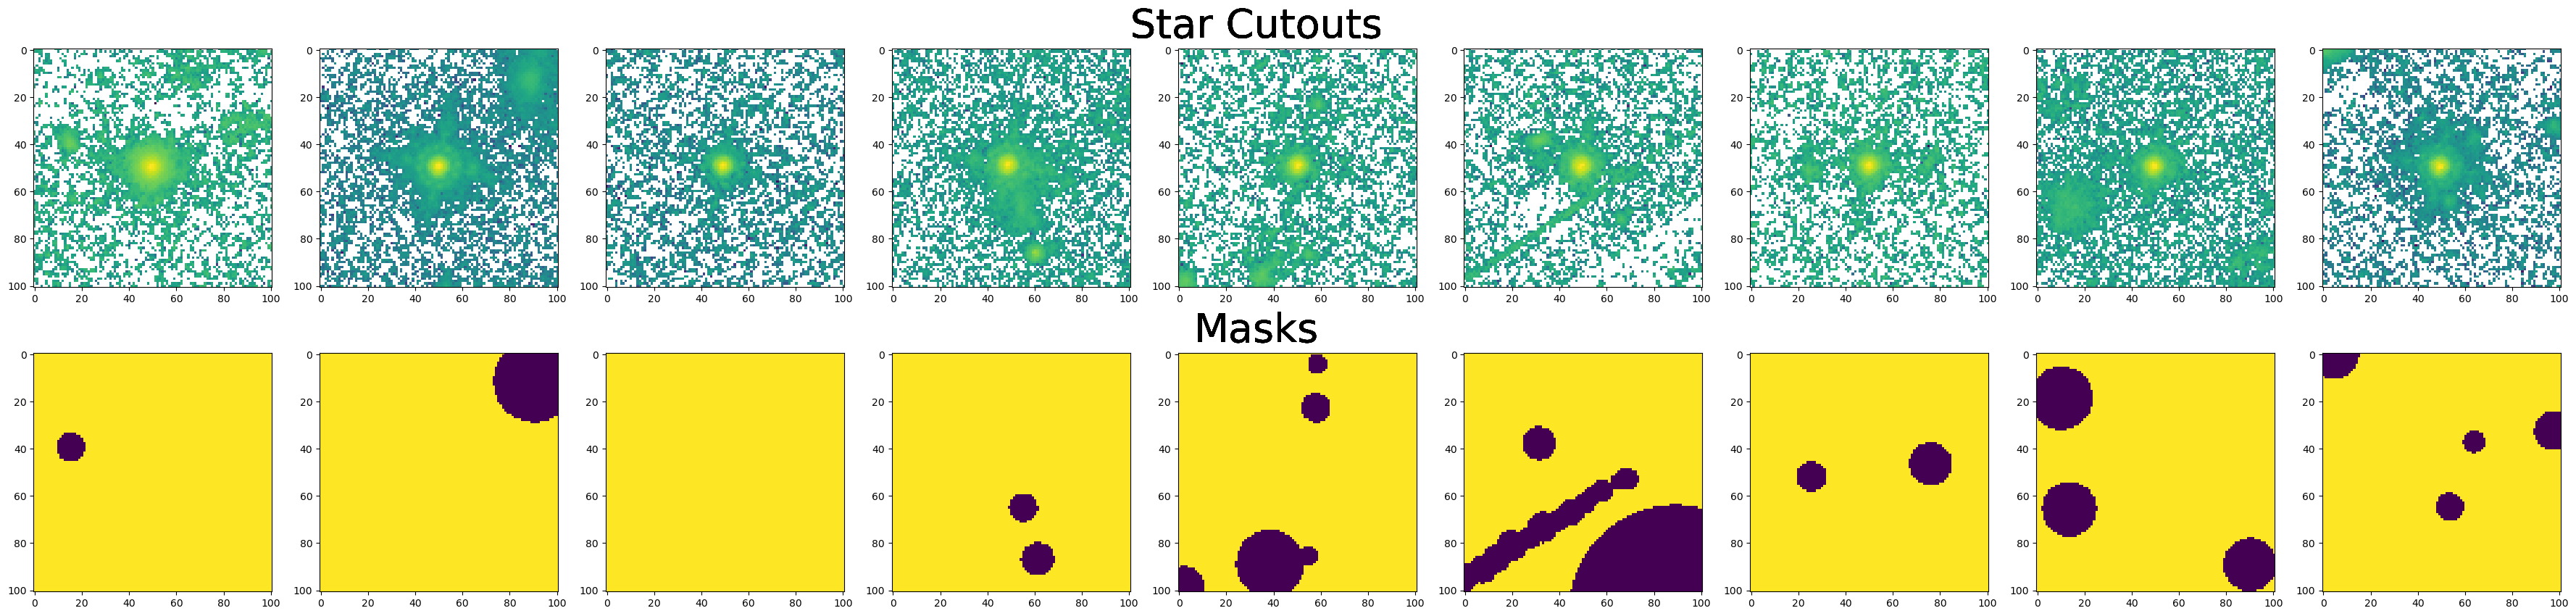

In [48]:
import glob
from astropy.io import fits
import numpy as np
from regions import Regions
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import re
import os

system_name = "J0806+2006"
filter = 'F160W'

# Get list of star FITS files and mask region files
star_list = glob.glob(f'../cutout_data/{system_name}/{filter}/stars/star*.fits')
mask_list = glob.glob(f'../cutout_data/{system_name}/{filter}/noise_maps/mask*.reg')

# Create a list to hold the numpy arrays
star_data_list = []
mask_data_list = []

# Loop through each star FITS file
for file in star_list:
    with fits.open(file) as hdul:
        data = hdul[0].data  
        star_data_list.append(np.array(data))  


with fits.open(star_list[0]) as hdul:
    image_shape = hdul[0].data.shape
    wcs = WCS(hdul[0].header)

# Automatically match masks by star number
for file in star_list:
    star_num = int(re.search(r'star_(\d+)', file).group(1))
    mask_path = f'../cutout_data/{system_name}/{filter}/noise_maps/mask_{star_num}.reg'

    if os.path.exists(mask_path):
        print(f'Using mask {mask_path} for star {star_num}!')
        regions = Regions.read(mask_path)

        mask = np.zeros(image_shape, dtype=bool)
        for region in regions:
            mask_region = region.to_mask(mode='center')
            region_mask = mask_region.to_image(image_shape)
            if region_mask is not None:
                mask |= region_mask.astype(bool)

        mask = ~mask
    else:
        print(f'No mask found for star {star_num}, using default (all True).')
        mask = np.ones(image_shape, dtype=bool)

    mask_data_list.append(mask)

def make_mask_grid(star_list, mask_list):

    fig, ax = plt.subplots(2, len(star_list), figsize=(len(star_list) * 5, 10))

    for i, star in enumerate(star_list):

        ax[0, i].imshow(np.log10(star))
        ax[1, i].imshow(mask_list[i], vmin=0, vmax=1)

        fig.text(0.5, 0.9, 'Star Cutouts', ha='center', va='center', fontsize=40)
        fig.text(0.5, 0.48, 'Masks', ha='center', va='center', fontsize=40)


    plt.show()

make_mask_grid(star_data_list, mask_data_list)

psf_returns = stack_psf(star_list = star_data_list, oversampling = 3, mask_list=mask_data_list)

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_3321/2452110322.py:6: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(psf_guess), origin='lower', cmap='viridis')


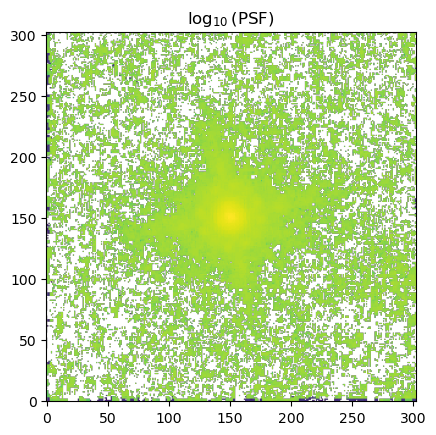

In [49]:
psf_guess = psf_returns[0]
center_list = np.array(psf_returns[1])
save_psf = False

# Plot the PSF for visualization
plt.imshow(np.log10(psf_guess), origin='lower', cmap='viridis')
plt.title(r'$\log_{10}$(PSF)')
plt.show()

if save_psf == True:
    # Save the PSF to a FITS file
    hdu = fits.PrimaryHDU(psf_guess)
    hdul = fits.HDUList([hdu])
    hdul.writeto(f'../cutout_data/{system_name}/{filter}/outputs/full_PSF.fits', overwrite=True)

# Process the center list
new_center_list = []

for i, star in enumerate(center_list):
    new_center_list.append([center_list[i][0], center_list[i][1]])

new_center_list = np.array(new_center_list)


Text(0.5, 1.0, '$\\sigma^2$')

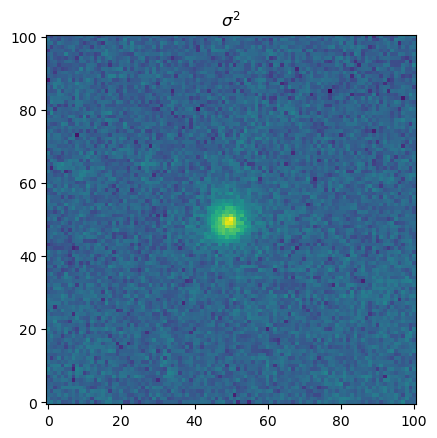

In [50]:
error_map = psf_error(star_data_list, psf_guess, new_center_list, oversampling=3, mask_list=mask_data_list)

plt.imshow(np.log10(error_map), origin='lower')
plt.title(r'$\sigma^2$')

In [5]:
np.savetxt(f'../cutout_data/{system_name}/{filter}/psf_variance.txt', error_map)